In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [36]:


print("Comenzando el preprocesamiento de datos...")

dataset_path = 'dataset'  

IMG_SIZE = 128

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            labels.append(label)
    return images, labels

categories = ['asalto', 'robo_casa', 'tornado', 'inundacion', 'incendio']
all_images = []
all_labels = []

print("Cargando imágenes...")

for idx, category in enumerate(categories):
    folder_path = os.path.join(dataset_path, category)
    images, labels = load_images_from_folder(folder_path, idx)
    all_images.extend(images)
    all_labels.extend(labels)
    print(f"Categoría '{category}' cargada con {len(images)} imágenes.")

X = np.array(all_images)
y = np.array(all_labels)

print("Normalizando imágenes...")

X = X / 255.0

print("Dividiendo el dataset en conjuntos de entrenamiento, validación y prueba...")

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42)

print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de validación: {len(X_val)}")
print(f"Datos de prueba: {len(X_test)}")




Comenzando el preprocesamiento de datos...
Cargando imágenes...
Categoría 'asalto' cargada con 1309 imágenes.
Categoría 'robo_casa' cargada con 1083 imágenes.
Categoría 'tornado' cargada con 677 imágenes.
Categoría 'inundacion' cargada con 762 imágenes.
Categoría 'incendio' cargada con 1295 imágenes.
Normalizando imágenes...
Dividiendo el dataset en conjuntos de entrenamiento, validación y prueba...
Datos de entrenamiento: 3587
Datos de validación: 770
Datos de prueba: 769


In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Configurando el aumento de datos...")

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)



Configurando el aumento de datos...


In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

print("Construyendo el modelo CNN ajustado...")

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax') 
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])




Construyendo el modelo CNN ajustado...


In [39]:
print("Entrenando el modelo ajustado...")

history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_val, y_val))



Entrenando el modelo ajustado...
Epoch 1/50
113/113 [==============================] - 35s 288ms/step - loss: 1.4363 - accuracy: 0.4313 - val_loss: 1.6427 - val_accuracy: 0.2299
Epoch 2/50
113/113 [==============================] - 31s 272ms/step - loss: 1.1213 - accuracy: 0.5442 - val_loss: 1.6570 - val_accuracy: 0.2883
Epoch 3/50
113/113 [==============================] - 31s 271ms/step - loss: 1.0194 - accuracy: 0.5771 - val_loss: 1.5000 - val_accuracy: 0.3974
Epoch 4/50
113/113 [==============================] - 31s 273ms/step - loss: 0.9411 - accuracy: 0.6172 - val_loss: 1.2154 - val_accuracy: 0.5169
Epoch 5/50
113/113 [==============================] - 31s 272ms/step - loss: 0.8915 - accuracy: 0.6370 - val_loss: 0.8203 - val_accuracy: 0.6701
Epoch 6/50
113/113 [==============================] - 31s 274ms/step - loss: 0.8510 - accuracy: 0.6543 - val_loss: 0.7342 - val_accuracy: 0.7078
Epoch 7/50
113/113 [==============================] - 33s 288ms/step - loss: 0.8206 - accuracy: 0

In [40]:
print("Evaluando el modelo ajustado...")

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {test_acc}")


Evaluando el modelo ajustado...
25/25 [==============================] - 1s 58ms/step - loss: 0.2585 - accuracy: 0.9181
Precisión en el conjunto de prueba: 0.918075442314148


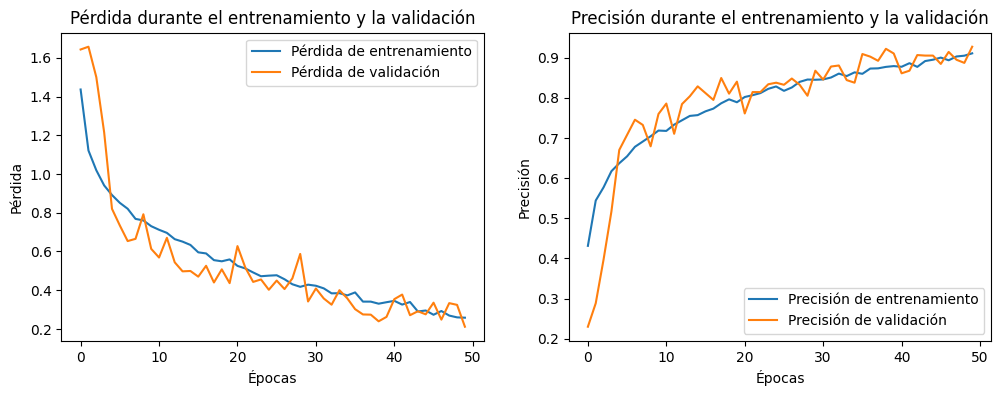

In [41]:
import matplotlib.pyplot as plt

# Curvas de pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Curvas de precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()




25/25 [==============================] - 2s 60ms/step


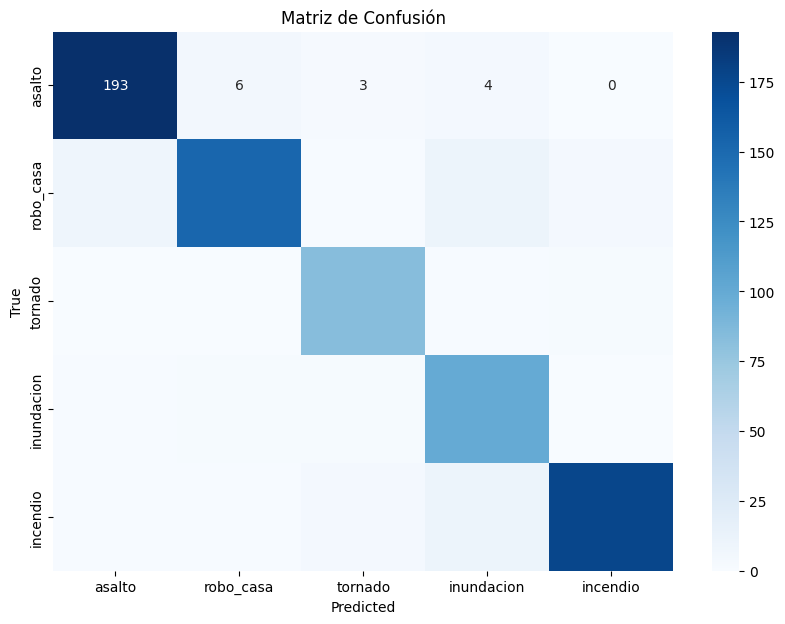

Informe de Clasificación:
              precision    recall  f1-score   support

      asalto       0.95      0.94      0.94       206
   robo_casa       0.94      0.86      0.90       178
     tornado       0.89      0.97      0.93        86
  inundacion       0.79      0.95      0.86       105
    incendio       0.97      0.91      0.94       194

    accuracy                           0.92       769
   macro avg       0.91      0.93      0.91       769
weighted avg       0.92      0.92      0.92       769



In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

class_report = classification_report(y_test, y_pred_classes, target_names=categories)
print("Informe de Clasificación:")
print(class_report)



In [43]:
model.save('modelo_cnn_peligros.h5')
print("Modelo guardado.")


Modelo guardado.


C:\Users\super\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('modelo_cnn_peligros.h5')
print("Modelo cargado.")





Modelo cargado.


In [3]:
def predecir_imagen(model, img_path, img_size=128):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (img_size, img_size))
    img_resized = img_resized.astype('float32') / 255.0
    img_resized = np.expand_dims(img_resized, axis=0) 
    
    pred = model.predict(img_resized)
    pred_clase = np.argmax(pred, axis=1)
    
    categorias = ['asalto', 'robo_casa', 'tornado', 'inundacion', 'incendio']
    pred_categoria = categorias[pred_clase[0]]
    
    return img, pred_categoria

def probar_carpeta(model, carpeta_path, img_size=128):
    for filename in os.listdir(carpeta_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(carpeta_path, filename)
            img, pred_categoria = predecir_imagen(model, img_path, img_size)
            
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f'Predicción: {pred_categoria}')
            plt.axis('off')
            plt.show()
            print(f'La imagen {filename} se clasifica como: {pred_categoria}')

# Cargar el modelo entrenado
model = load_model('modelo_cnn_peligros.h5')
print("Modelo cargado.")


Modelo cargado.


1/1 [==============================] - 0s 61ms/step


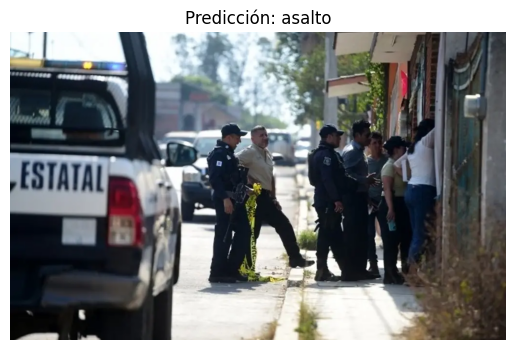

La imagen 1326311xeu20240603191141.jpg se clasifica como: asalto


In [15]:
carpeta_test = './test'
probar_carpeta(model, carpeta_test)
